# Load time series data

            Hayfever rate
Week                     
2003-12-29          14.94
2004-01-05           3.96
2004-01-12           5.27
2004-01-19           4.99
2004-01-26           5.10


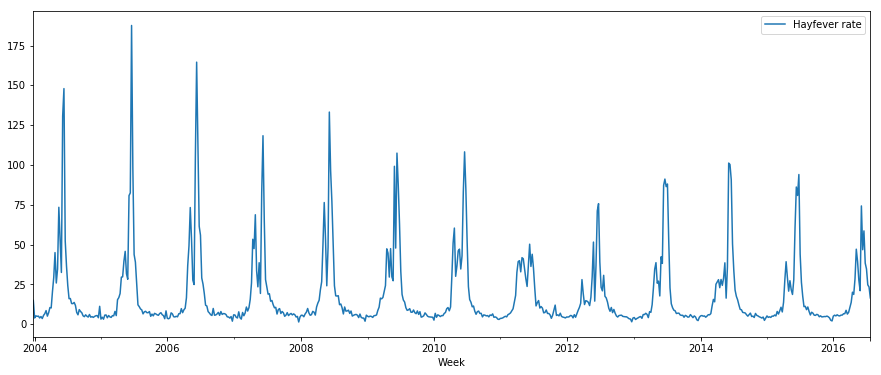

In [1]:
from pandas import read_csv
import pandas as pd
from pandas import datetime
from matplotlib import pyplot
from matplotlib.pylab import rcParams
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.mlab as mlab
#from scipy import stats 
#import seaborn as sns
rcParams['figure.figsize'] = 15, 6

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
series = read_csv('/Users/Helen/Documents/Data/hayfever_ENG.csv', parse_dates=['Week'],
                   index_col=['Week'],date_parser=dateparse)
#load the RCGP data which represents the number of doctor consultations reporting hayfever symptoms per 100,000 people in England. The data’s weekly time series are from January 5, 2004 to July 25, 2016. 
print(series.head())
series.plot()
pyplot.show()

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


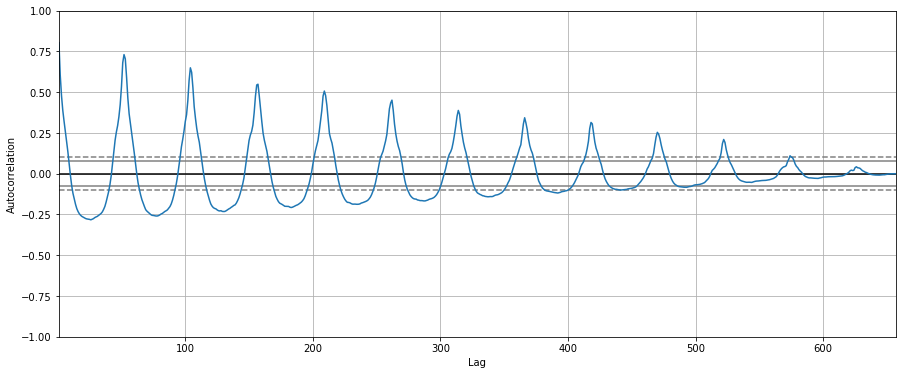

In [2]:
from pandas.plotting import autocorrelation_plot
from pandas.core import datetools
autocorrelation_plot(series)
pyplot.show()

# 5-fold cross validation

In [3]:
# create 5 ARIMA models by using different size of training data
X = series.values
train1, test1 = X[0:397], X[397:449] # train: 2004-2011 test: 2011-2012 ARIMA1
train2, test2 = X[0:449], X[449:501] # train: 2004-2012 test: 2012-2013 ARIMA2
train3, test3 = X[0:501], X[501:553] # train: 2004-2013 test: 2013-2014 ARIMA3
train4, test4 = X[0:553], X[553:605] # train: 2004-2014 test: 2014-2015 ARIMA4
train5, test5 = X[0:605], X[605:657] # train: 2004-2015 test: 2015-2016 ARIMA5
L1=series[397:449].index
L2=series[449:501].index
L3=series[501:553].index
L4=series[553:605].index
L5=series[605:657].index

In [4]:
ts5=series['Hayfever rate'][0:605] #5
ts4=series['Hayfever rate'][0:553] #4
ts3=series['Hayfever rate'][0:501] #3
ts2=series['Hayfever rate'][0:449] #2
ts1=series['Hayfever rate'][0:397] #1

# ARIMA1

## Stationality test of train data  2004-2011

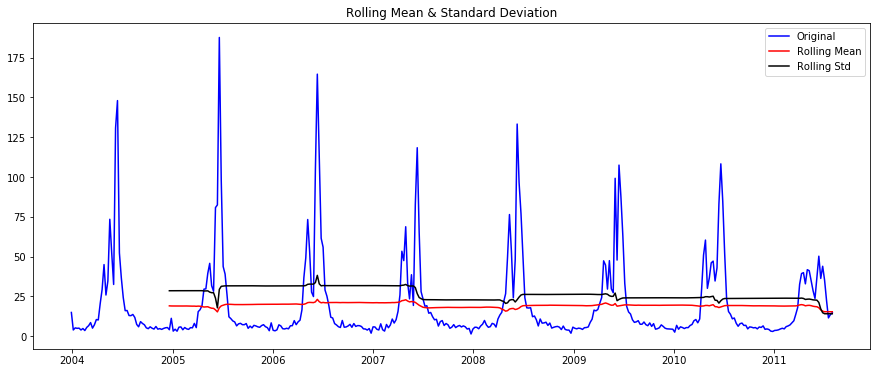

Results of Dickey-Fuller Test:
Test Statistic                -6.015859e+00
p-value                        1.534339e-07
#Lags Used                     2.000000e+00
Number of Observations Used    3.940000e+02
Critical Value (1%)           -3.447057e+00
Critical Value (5%)           -2.868904e+00
Critical Value (10%)          -2.570693e+00
dtype: float64


In [5]:
#the results show that all series are stationary.
from statsmodels.tsa.stattools import adfuller, acf, pacf
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
test_stationarity(ts1)

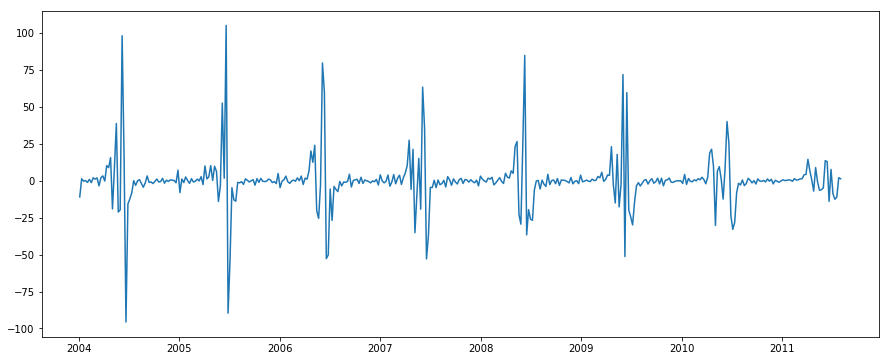

In [6]:
ts1_diff = ts1 - ts1.shift()
plt.plot(ts1_diff)
ts1_diff.dropna(inplace=True)

## ACF and PACF plots

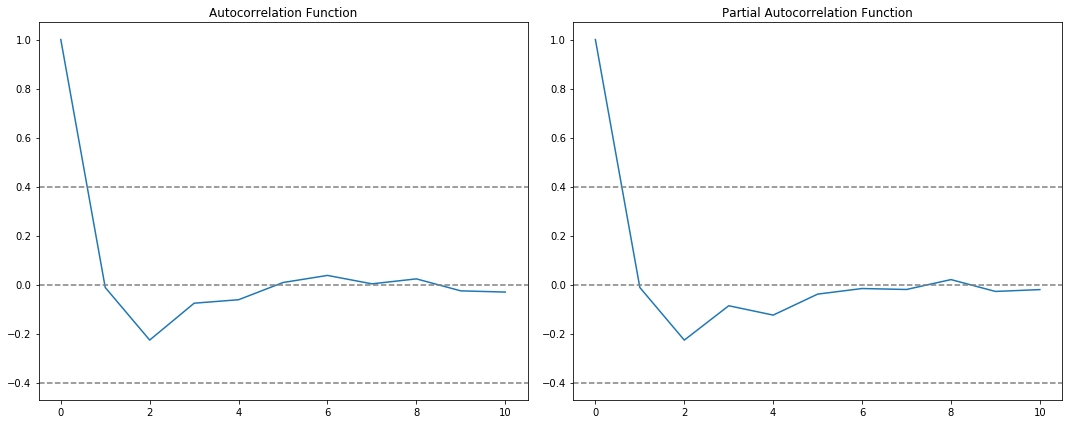

In [7]:
#ACF and PACF plots for determining p and q 

lag_acf = acf(ts1_diff, nlags=10)
lag_pacf = pacf(ts1_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts1_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts1_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts1_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts1_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

train, test = X[0:366], X[366:418]
L=series[366:418].index
len(train)

import statsmodels.api as sm
mod = sm.tsa.SARIMAX(endog = test,order=(1,1,1))
fit_res = mod.fit(disp=0)
print(fit_res.summary())
predictions=fit_res.predict()

## ARIMA1 training 

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

history = [x for x in train1]
predictions1 = list()
for t in range(len(test1)):
    model1 = ARIMA(history, order=(1,1,1))
    model_fit1 = model1.fit(disp=0)
    output = model_fit1.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = test1[t]
    history.append(obs)


In [9]:
print(model_fit1.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  447
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1867.503
Method:                       css-mle   S.D. of innovations             15.712
Date:                Wed, 06 Sep 2017   AIC                           3743.006
Time:                        20:04:56   BIC                           3759.416
Sample:                             1   HQIC                          3749.476
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.026     -0.188      0.851      -0.056       0.046
ar.L1.D.y      0.7859      0.030     26.608      0.000       0.728       0.844
ma.L1.D.y     -1.0000      0.006   -177.776      0.0

In [10]:
df1 = pd.DataFrame(data=predictions1,index=L1,columns=['predictive_rate'])
df1_ = pd.DataFrame(data=test1, index=L1,columns=["real hayfever rate"])

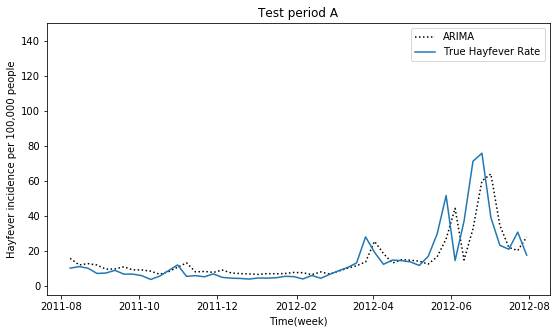

In [11]:
plt.figure(figsize=(9,5))
plt.ylim((-5, 150))
line_up, = plt.plot(df1, label='ARIMA',color='black',linestyle=':')
line_down, = plt.plot(df1_, label='True Hayfever Rate')
plt.legend(handles=[line_up, line_down])
plt.ylabel("Hayfever incidence per 100,000 people")
plt.xlabel("Time(week)")
plt.title('Test period A')
#plt.title('RMSE: %.4f'% rmse )
pyplot.show()


## RMSE&MAE&Pearson corrleation of ARIMA1

In [12]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_absolute_error
from scipy.stats.stats import pearsonr   
MSE1 = mean_squared_error(test1, predictions1, sample_weight=None, multioutput='uniform_average')
RMSE1=np.sqrt(MSE1)
MAE1 = mean_absolute_error(test1, predictions1, sample_weight=None, multioutput='uniform_average')
print("RMSE %.4f" % RMSE1)
print("MAE %.4f" % MAE1)
r1=pearsonr(test1, predictions1)
print(r1)

RMSE 10.2562
MAE 6.1737
(array([ 0.75047181]), array([  1.49815667e-10]))


# ARIMA2

## Stationality test of train data 2004-2012

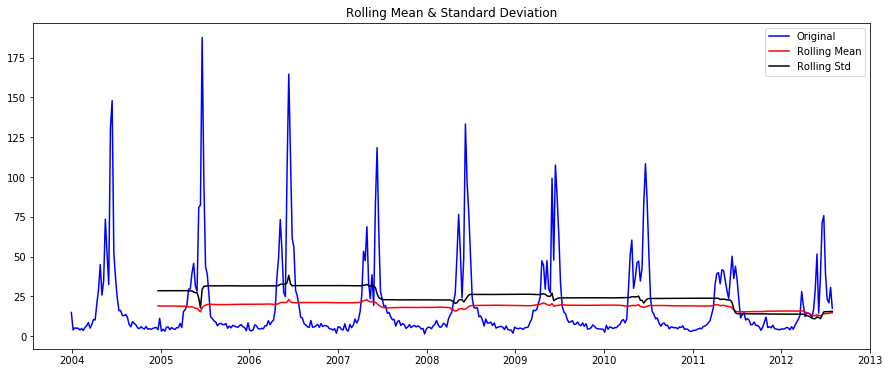

Results of Dickey-Fuller Test:
Test Statistic                -6.336319e+00
p-value                        2.824930e-08
#Lags Used                     2.000000e+00
Number of Observations Used    4.460000e+02
Critical Value (1%)           -3.445097e+00
Critical Value (5%)           -2.868042e+00
Critical Value (10%)          -2.570233e+00
dtype: float64


In [13]:
#the results show that all series are stationary.
test_stationarity(ts2)

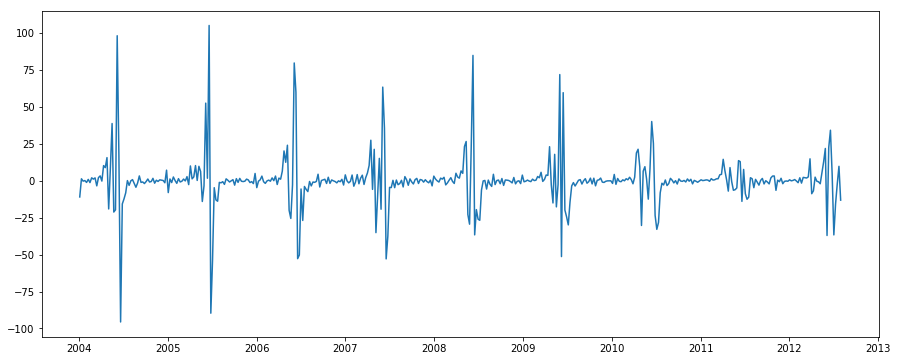

In [14]:
ts2_diff = ts2 - ts2.shift()
plt.plot(ts2_diff)
ts2_diff.dropna(inplace=True)

## ACF and PACF plots

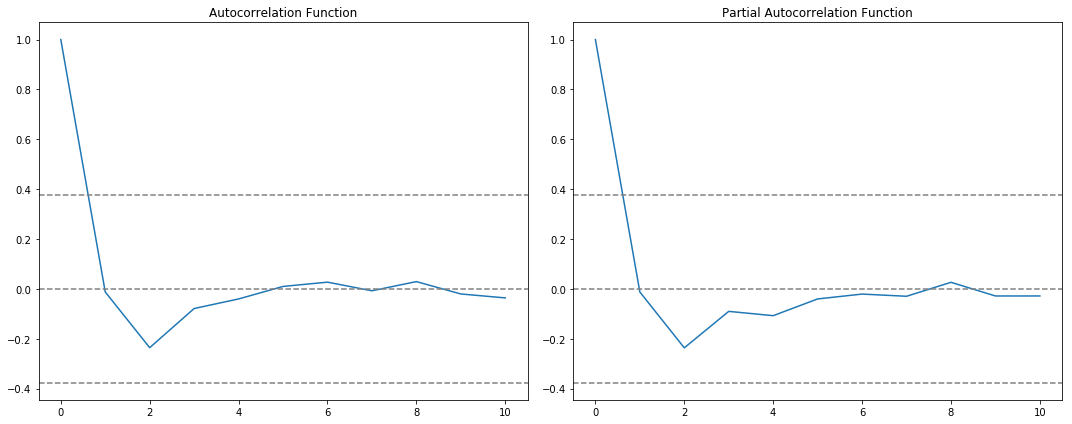

In [15]:
#ACF and PACF plots for determining p and q 

lag_acf = acf(ts2_diff, nlags=10)
lag_pacf = pacf(ts2_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts2_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts2_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts2_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts2_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## ARIMA2 Training

In [16]:
history = [x for x in train2]
predictions2 = list()
for t in range(len(test2)):
    model2 = ARIMA(history, order=(1,1,1))
    model_fit2 = model2.fit(disp=0)
    output = model_fit2.forecast()
    yhat = output[0]
    predictions2.append(yhat)
    obs = test2[t]
    history.append(obs)

In [17]:
print(model_fit2.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  499
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2070.271
Method:                       css-mle   S.D. of innovations             15.269
Date:                Wed, 06 Sep 2017   AIC                           4148.542
Time:                        20:05:07   BIC                           4165.393
Sample:                             1   HQIC                          4155.155
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.023     -0.194      0.846      -0.049       0.040
ar.L1.D.y      0.7956      0.027     29.079      0.000       0.742       0.849
ma.L1.D.y     -1.0000      0.005   -197.813      0.0

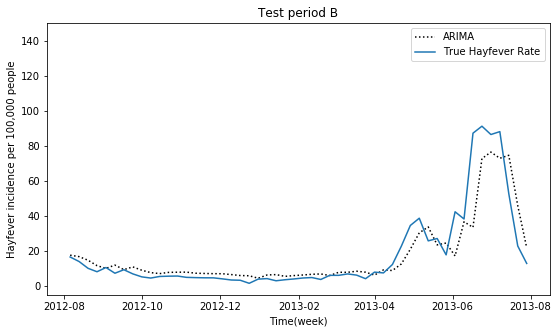

In [18]:
df2 = pd.DataFrame(data=predictions2,index=L2,columns=['predictive_rate'])
df2_ = pd.DataFrame(data=test2, index=L2,columns=["real hayfever rate"])
plt.figure(figsize=(9,5))
plt.ylim((-5, 150))
line_up, = plt.plot(df2, label='ARIMA',color='black',linestyle=':')
line_down, = plt.plot(df2_, label='True Hayfever Rate')
plt.legend(handles=[line_up, line_down])
plt.ylabel("Hayfever incidence per 100,000 people")
plt.xlabel("Time(week)")
plt.title('Test period B')
#plt.title('RMSE: %.4f'% rmse )
pyplot.show()


## RMSE&MAE&Pearson corrleation of ARIMA2

In [19]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_absolute_error
from scipy.stats.stats import pearsonr   
MSE2 = mean_squared_error(test2, predictions2, sample_weight=None, multioutput='uniform_average')
RMSE2=np.sqrt(MSE2)
MAE2 = mean_absolute_error(test2, predictions2, sample_weight=None, multioutput='uniform_average')
print("RMSE %.4f" % RMSE2)
print("MAE %.4f" % MAE2)
r2=pearsonr(test2, predictions2)
print(r2)

RMSE 10.7674
MAE 6.1140
(array([ 0.89178017]), array([  7.53942991e-19]))


# ARIMA3

## Stationality test of train data 2004-2013

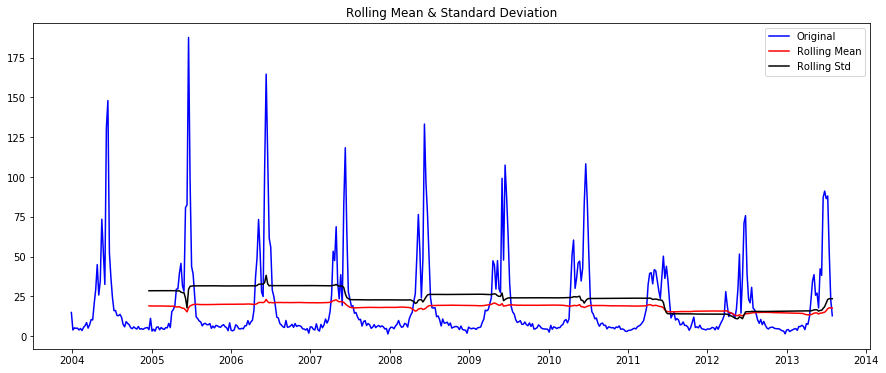

Results of Dickey-Fuller Test:
Test Statistic                -6.719392e+00
p-value                        3.514438e-09
#Lags Used                     2.000000e+00
Number of Observations Used    4.980000e+02
Critical Value (1%)           -3.443549e+00
Critical Value (5%)           -2.867361e+00
Critical Value (10%)          -2.569870e+00
dtype: float64


In [20]:
#the results show that all series are stationary.
from statsmodels.tsa.stattools import adfuller, acf, pacf
test_stationarity(ts3)

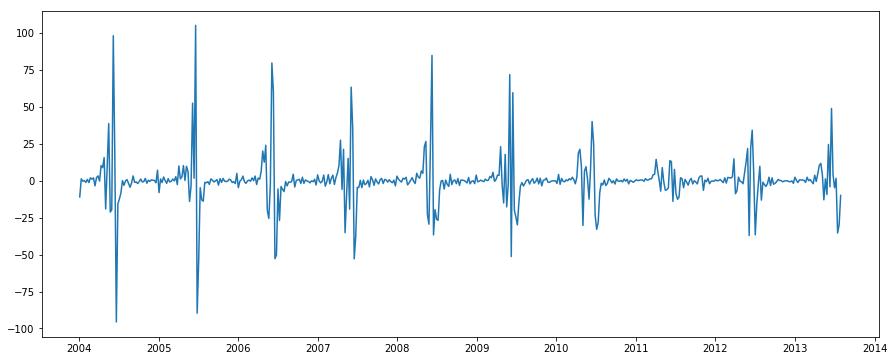

In [21]:
ts3_diff = ts3 - ts3.shift()
plt.plot(ts3_diff)
ts3_diff.dropna(inplace=True)

## ACF and PACF plots

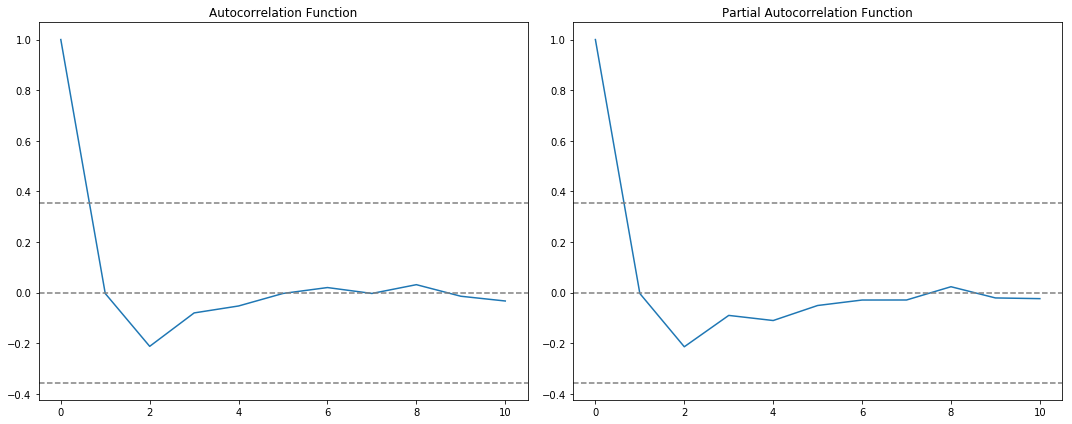

In [22]:
#ACF and PACF plots for determining p and q 

lag_acf = acf(ts3_diff, nlags=10)
lag_pacf = pacf(ts3_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts3_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts3_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts3_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts3_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## ARIMA3 Training

In [23]:
history = [x for x in train3]
predictions3 = list()
for t in range(len(test3)):
    model3 = ARIMA(history, order=(1,1,1))
    model_fit3 = model3.fit(disp=0)
    output = model_fit3.forecast()
    yhat = output[0]
    predictions3.append(yhat)
    obs = test3[t]
    history.append(obs)
print(model_fit3.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  551
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2275.269
Method:                       css-mle   S.D. of innovations             14.980
Date:                Wed, 06 Sep 2017   AIC                           4558.537
Time:                        20:05:22   BIC                           4575.784
Sample:                             1   HQIC                          4565.276
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.020     -0.202      0.840      -0.042       0.034
ar.L1.D.y      0.8001      0.026     31.055      0.000       0.750       0.851
ma.L1.D.y     -0.9999      0.005   -218.320      0.0

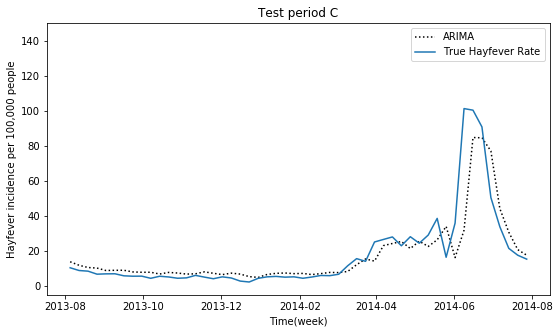

In [24]:
df3 = pd.DataFrame(data=predictions3,index=L3,columns=['predictive_rate'])
df3_ = pd.DataFrame(data=test3, index=L3,columns=["real hayfever rate"])
plt.figure(figsize=(9,5))
plt.ylim((-5, 150))
line_up, = plt.plot(df3, label='ARIMA',color='black',linestyle=':')
line_down, = plt.plot(df3_, label='True Hayfever Rate')
plt.legend(handles=[line_up, line_down])
plt.ylabel("Hayfever incidence per 100,000 people")
plt.xlabel("Time(week)")
plt.title('Test period C')
#plt.title('RMSE: %.4f'% rmse )
pyplot.show()


## RMSE&MAE&Pearson corrleation of ARIMA3

In [25]:

MSE3 = mean_squared_error(test3, predictions3, sample_weight=None, multioutput='uniform_average')
RMSE3=np.sqrt(MSE3)
MAE3 = mean_absolute_error(test3, predictions3, sample_weight=None, multioutput='uniform_average')
print("RMSE %.4f" % RMSE3)
print("MAE %.4f" % MAE3)
r3=pearsonr(test3, predictions3)
print(r3)

RMSE 11.8456
MAE 5.8703
(array([ 0.85225835]), array([  1.11360479e-15]))


# ARIMA4

## Stationality test of train data 2004-2014

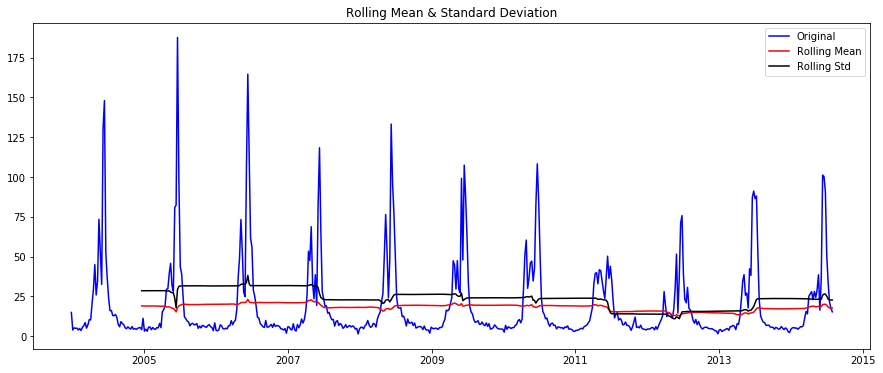

Results of Dickey-Fuller Test:
Test Statistic                -7.115383e+00
p-value                        3.842973e-10
#Lags Used                     2.000000e+00
Number of Observations Used    5.500000e+02
Critical Value (1%)           -3.442296e+00
Critical Value (5%)           -2.866809e+00
Critical Value (10%)          -2.569576e+00
dtype: float64


In [26]:
test_stationarity(ts4)

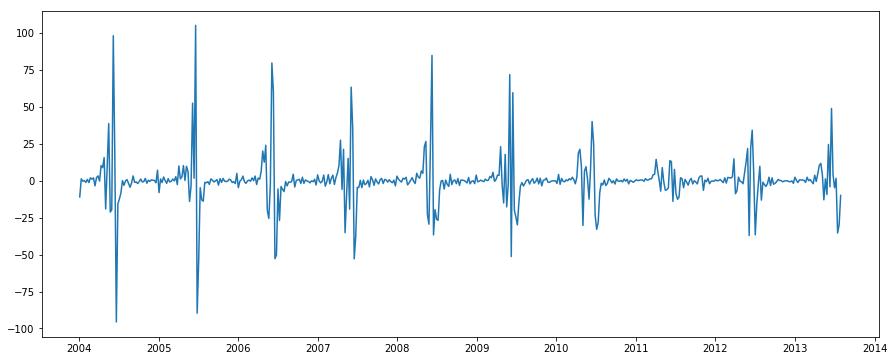

In [27]:
ts4_diff = ts3 - ts4.shift()
plt.plot(ts4_diff)
ts4_diff.dropna(inplace=True)

## ACF and PACF plots 

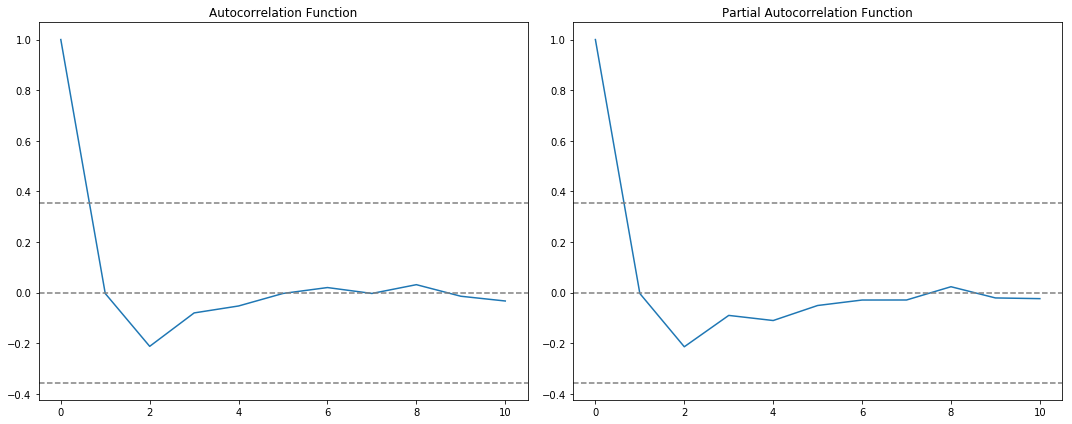

In [28]:
#ACF and PACF plots for determining p and q 

lag_acf = acf(ts4_diff, nlags=10)
lag_pacf = pacf(ts4_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts4_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts4_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts4_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts4_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## ARIMA4 training

In [29]:
history = [x for x in train4]
predictions4 = list()
for t in range(len(test4)):
    model4 = ARIMA(history, order=(2,1,1))
    model_fit4 = model4.fit(disp=0)
    output = model_fit4.forecast()
    yhat = output[0]
    predictions4.append(yhat)
    obs = test4[t]
    history.append(obs)
print(model_fit4.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  603
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2470.414
Method:                       css-mle   S.D. of innovations             14.501
Date:                Wed, 06 Sep 2017   AIC                           4950.828
Time:                        20:05:36   BIC                           4972.837
Sample:                             1   HQIC                          4959.394
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.015     -0.290      0.772      -0.034       0.025
ar.L1.D.y      0.9089      0.040     22.519      0.000       0.830       0.988
ar.L2.D.y     -0.1296      0.040     -3.211      0.0

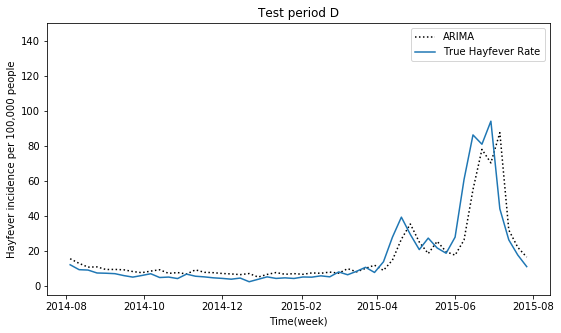

In [30]:
df4 = pd.DataFrame(data=predictions4,index=L4,columns=['predictive_rate'])
df4_ = pd.DataFrame(data=test4, index=L4,columns=["real hayfever rate"])
plt.figure(figsize=(9,5))
plt.ylim((-5, 150))
line_up, = plt.plot(df4, label='ARIMA',color='black',linestyle=':')
line_down, = plt.plot(df4_, label='True Hayfever Rate')
plt.legend(handles=[line_up, line_down])
plt.ylabel("Hayfever incidence per 100,000 people")
plt.xlabel("Time(week)")
plt.title('Test period D')
#plt.title('RMSE: %.4f'% rmse )
pyplot.show()


## RMSE&MAE&Pearson corrleation of ARIMA4

In [31]:
MSE4 = mean_squared_error(test4, predictions4, sample_weight=None, multioutput='uniform_average')
RMSE4=np.sqrt(MSE4)
MAE4 = mean_absolute_error(test4, predictions4, sample_weight=None, multioutput='uniform_average')
print("RMSE %.4f" % RMSE4)
print("MAE %.4f" % MAE4)
r4=pearsonr(test4, predictions4)
print(r4)

RMSE 10.3476
MAE 5.8081
(array([ 0.87029059]), array([  5.37027648e-17]))


# ARIMA5

## Stationality test of train data 2004-2015

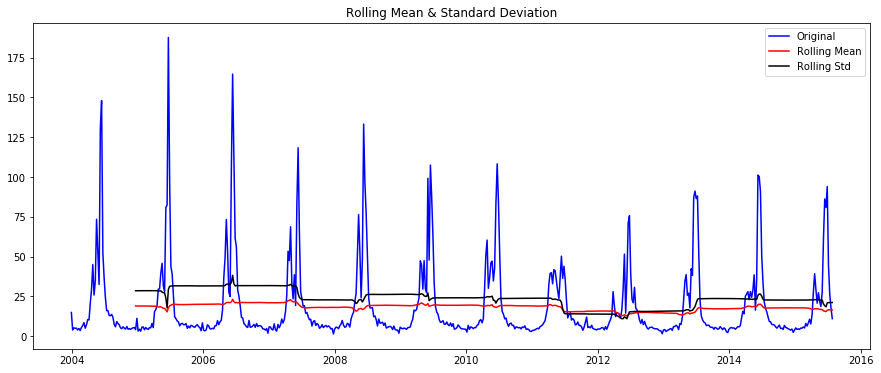

Results of Dickey-Fuller Test:
Test Statistic                -7.506169e+00
p-value                        4.129208e-11
#Lags Used                     2.000000e+00
Number of Observations Used    6.020000e+02
Critical Value (1%)           -3.441259e+00
Critical Value (5%)           -2.866353e+00
Critical Value (10%)          -2.569333e+00
dtype: float64


In [32]:
test_stationarity(ts5)

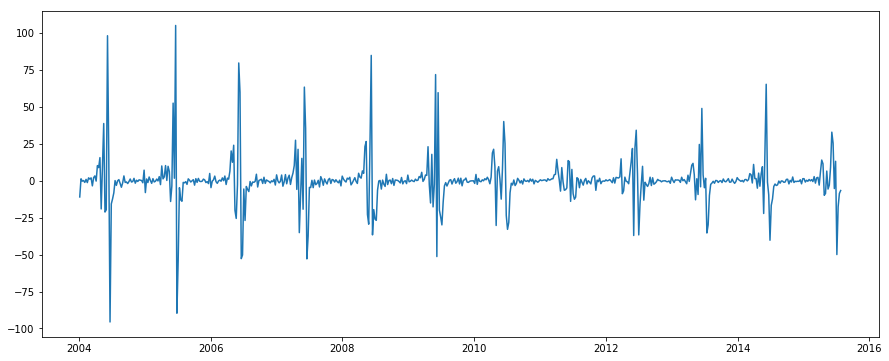

In [33]:
ts5_diff = ts5 - ts5.shift()
plt.plot(ts5_diff)
ts5_diff.dropna(inplace=True)

## ACF and PACF plots 

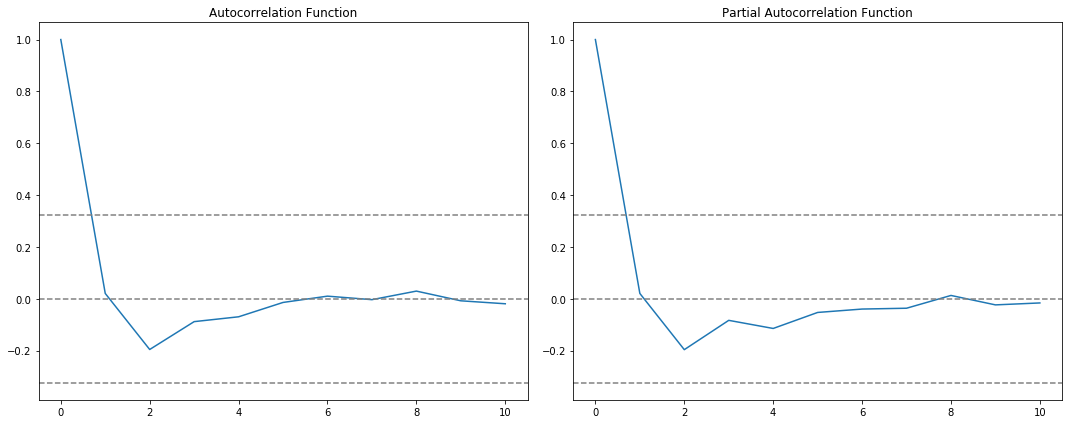

In [34]:
#ACF and PACF plots for determining p and q 

lag_acf = acf(ts5_diff, nlags=10)
lag_pacf = pacf(ts5_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts5_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts5_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts5_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts5_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## ARIMA5 Training

In [35]:
history = [x for x in train5]
predictions5 = list()
for t in range(len(test5)):
    model5 = ARIMA(history, order=(1,1,1))
    model_fit5 = model5.fit(disp=0)
    output = model_fit5.forecast()
    yhat = output[0]
    predictions5.append(yhat)
    obs = test5[t]
    history.append(obs)
print(model_fit5.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  655
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2673.241
Method:                       css-mle   S.D. of innovations             14.283
Date:                Wed, 06 Sep 2017   AIC                           5354.483
Time:                        20:05:53   BIC                           5372.421
Sample:                             1   HQIC                          5361.438
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.015     -0.353      0.724      -0.034       0.024
ar.L1.D.y      0.8049      0.023     34.463      0.000       0.759       0.851
ma.L1.D.y     -1.0000      0.004   -261.618      0.0

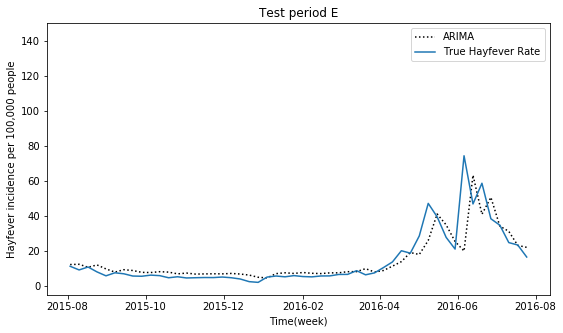

In [36]:
df5 = pd.DataFrame(data=predictions5,index=L5,columns=['predictive_rate'])
df5_ = pd.DataFrame(data=test5, index=L5,columns=["real hayfever rate"])
plt.figure(figsize=(9,5))
plt.ylim((-5, 150))
line_up, = plt.plot(df5, label='ARIMA',color='black',linestyle=':')
line_down, = plt.plot(df5_, label='True Hayfever Rate')
plt.legend(handles=[line_up, line_down])
plt.ylabel("Hayfever incidence per 100,000 people")
plt.xlabel("Time(week)")
plt.title('Test period E')
#plt.title('RMSE: %.4f'% rmse )
pyplot.show()

## RMSE&MAE&Pearson corrleation of ARIMA5

In [37]:
MSE5 = mean_squared_error(test5, predictions5, sample_weight=None, multioutput='uniform_average')
RMSE5=np.sqrt(MSE5)
MAE5 = mean_absolute_error(test5, predictions5, sample_weight=None, multioutput='uniform_average')
print("RMSE %.4f" % RMSE5)
print("MAE %.4f" % MAE5)
r5=pearsonr(test5, predictions5)
print(r5)

RMSE 9.4213
MAE 4.6233
(array([ 0.79518826]), array([  1.91294427e-12]))
